# **Combining Logistic Regression and Naive Bayes with Word Embeddings for Improved Sentiment Analysis**

## Import Libraries and Data

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.corpus import twitter_samples
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.model_selection import train_test_split
import contractions

In [2]:
# Download required NLTK datasets
nltk.download('twitter_samples')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\kench\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kench\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kench\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load and Preprocess the Dataset

In [3]:
# Load positive and negative tweets
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

# Assign labels: 1 for positive, 0 for negative
positive_labels = [1] * len(positive_tweets)
negative_labels = [0] * len(negative_tweets)

# Combine and preprocess data
tweets = positive_tweets + negative_tweets
labels = positive_labels + negative_labels

In [4]:
print("Positive Tweets:")
for tweet in positive_tweets[:5]:
    print(tweet)

print("\nNegative Tweets:")
for tweet in negative_tweets[:5]:
    print(tweet)

Positive Tweets:
#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!
@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!
@97sides CONGRATS :)
yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days

Negative Tweets:
hopeless for tmr :(
Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(
@Hegelbon That heart sliding into the waste basket. :(
“@ketchBurning: I hate Japanese call him "bani" :( :(”

Me too
Dang starting next week I have "work" :(


In [5]:
# Preprocess tweets
def preprocess_tweet(text):
    text = contractions.fix(text)
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'very', 'absolutely', 'loved'}
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(tokens)

processed_tweets = [preprocess_tweet(tweet) for tweet in tweets]

In [6]:
# Split into training and test sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(processed_tweets, labels, test_size=0.2, random_state=42, stratify=labels)

## Create Word Embeddings using GloVe Embeddings

In [7]:
import gensim.downloader as api

# Load pre-trained GloVe embeddings
glove_vectors = api.load("glove-wiki-gigaword-100")

# Convert tweets into GloVe vectors
def tweet_to_glove_vector(tokens):
    vectors = [glove_vectors[word] for word in tokens if word in glove_vectors]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

# Generate GloVe embeddings for training and testing sets
X_train = np.array([tweet_to_glove_vector(tweet) for tweet in X_train_raw])
X_test = np.array([tweet_to_glove_vector(tweet) for tweet in X_test_raw])

## Vectorize Tweets using TF-IDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train_raw)
X_test_tfidf = tfidf.transform(X_test_raw)

## Training the Models

In [9]:
# Define the parameter grid for Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}

# Perform grid search with cross-validation
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)

# Get the best Logistic Regression model
best_lr_model = grid_search_lr.best_estimator_
print("Best C for Logistic Regression:", grid_search_lr.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best C for Logistic Regression: {'C': 10}


In [10]:
# Define the parameter grid for Naive Bayes
from sklearn.naive_bayes import MultinomialNB

param_grid_nb = {'alpha': [0.1, 0.5, 1, 5, 10]}

# Perform grid search with cross-validation
grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search_nb.fit(X_train_tfidf, y_train)

# Get the best Naive Bayes model
best_nb_model = grid_search_nb.best_estimator_
print("Best alpha for Naive Bayes:", grid_search_nb.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best alpha for Naive Bayes: {'alpha': 5}


## Stacking Classifier

In [11]:
#Combine the predictions of Logistic Regression and Naive Bayes using a stacking classifier

from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create Stacking Classifier
stacked_model = StackingClassifier(
    estimators=[('lr', best_lr_model), ('nb', best_nb_model)],
    final_estimator=LogisticRegression()
)

# Combine features (TF-IDF for NB, GloVe for LR)
from scipy.sparse import hstack

X_train_combined = hstack([X_train_tfidf, X_train])  # Combine TF-IDF and GloVe
X_test_combined = hstack([X_test_tfidf, X_test])    # Same for test set

# Clip negative values in combined matrix (if any)
X_train_combined = np.clip(X_train_combined.toarray(), 0, None)
X_test_combined = np.clip(X_test_combined.toarray(), 0, None)

# Train and evaluate the stacking model
stacked_model.fit(X_train_combined, y_train)
y_pred_stacked = stacked_model.predict(X_test_combined)

# Evaluate the model
print("Stacking Model Accuracy:", accuracy_score(y_test, y_pred_stacked))
print("Classification Report:\n", classification_report(y_test, y_pred_stacked))

Stacking Model Accuracy: 0.7665
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.79      0.77      1000
           1       0.78      0.75      0.76      1000

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000



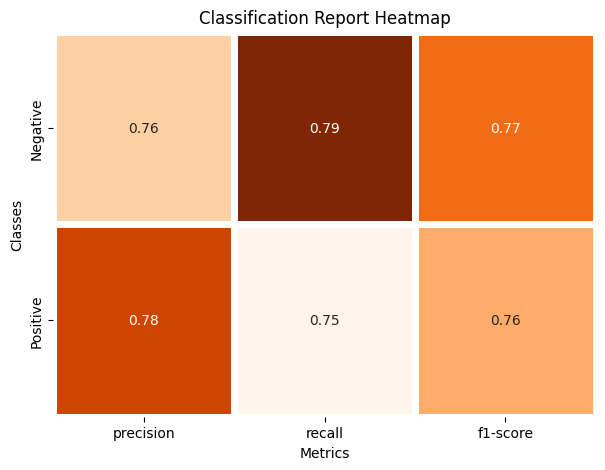

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Generate classification report as a dictionary
report = classification_report(y_test, y_pred_stacked, target_names=['Negative', 'Positive'], output_dict=True)

# Convert the dictionary to a DataFrame for visualization
report_df = pd.DataFrame(report).transpose()

# Filter out averages for clarity (optional)
class_metrics = report_df.iloc[:-3, :3]  # Only include 'precision', 'recall', 'f1-score' for classes

# Plot heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(class_metrics, annot=True, fmt=".2f", cmap="Oranges", cbar=False, linewidths=5)

plt.title("Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()

# Predict with own example

In [17]:
def classify_and_print_sentiment(sentence, stacked_model, tfidf_vectorizer):

    tokens = preprocess_tweet(sentence)
    glove_vector = tweet_to_glove_vector(tokens).reshape(1, -1)
    
    # Clip negative values (if any)
    dense_glove_vector = np.clip(glove_vector, 0, None)

    # Vectorize using TF-IDF
    tfidf_vector = tfidf_vectorizer.transform([" ".join(tokens)])

    # Combine GloVe and TF-IDF vectors
    from scipy.sparse import hstack
    combined_vector = hstack([tfidf_vector, dense_glove_vector])

    # Predict sentiment
    prediction = stacked_model.predict_proba(combined_vector)
    print("Prediction Probabilities:", prediction)
    sentiment = "Positive" if prediction[0][1] > 0.5 else "Negative"
    print(f"Sentence: \"{sentence}\" -> {sentiment} Sentiment")

In [28]:
sentence = "Our campus is not that good"
classify_and_print_sentiment(sentence, stacked_model, tfidf)

Prediction Probabilities: [[0.5113996 0.4886004]]
Sentence: "Our campus is not that good" -> Negative Sentiment
